# notes

all using pixelwise loss and equivalent scheduler params 

In [1]:
# make a cell print all the outputs instead of just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from pathlib import Path

data_dir = Path("./data")
data_fpath = data_dir / "2022-07-bmvc-report-02-old-experiment-00.csv"

import pandas as pd
df = pd.read_csv(data_fpath) 

def check_df(df):
    print(df.shape)
    print(df.dtypes)
    return df.head(5)

check_df(df)

(359, 7)
Name                   object
loss_mode              object
noise_mode             object
normal_class            int64
it                      int64
test_rocauc           float64
test/avg-precision    float64
dtype: object


,Name,loss_mode,noise_mode,normal_class,it,test_rocauc,test/avg-precision
0,mvtec_fcdd_20220515135339.normal_6.it_2,pixel-level-balanced,mvtec_gt,6,2,0.993393,0.479265
1,mvtec_fcdd_20220511154411.normal_6.it_0,pixel-level-balanced,mvtec_gt,6,0,0.992960,0.435064
2,mvtec_fcdd_20220515135339.normal_3.it_0,pixel-level-balanced,mvtec_gt,3,0,0.992151,0.751474
3,mvtec_fcdd_20220515135339.normal_6.it_0,pixel-level-balanced,mvtec_gt,6,0,0.991963,0.389108
4,mvtec_fcdd_20220518111336.normal_3.it_0,pixel-wise-averages-per-image,mvtec_gt,3,0,0.991878,0.737411


In [3]:
# copy paste from mvtec_dataset_dev01_bis
CLASSES_LABELS = (
    'bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather',
    'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor',
    'wood', 'zipper'
)

CLASSES_FULLQUALIFIED = tuple(
    f"{idx:02d}_{label}" 
    for idx, label in enumerate(CLASSES_LABELS)
)

CLASS_TYPE_OBJECT = 'object'
CLASS_TYPE_TEXTURE = "texture"
CLASSES_TYPES = (
    CLASS_TYPE_OBJECT, CLASS_TYPE_OBJECT, CLASS_TYPE_OBJECT, CLASS_TYPE_TEXTURE, CLASS_TYPE_TEXTURE, CLASS_TYPE_OBJECT, CLASS_TYPE_TEXTURE,
    CLASS_TYPE_OBJECT, CLASS_TYPE_OBJECT, CLASS_TYPE_OBJECT, CLASS_TYPE_TEXTURE, CLASS_TYPE_OBJECT, CLASS_TYPE_OBJECT,
    CLASS_TYPE_TEXTURE, CLASS_TYPE_OBJECT
)

In [4]:
data_df = pd.read_csv(data_fpath) 
df = data_df
df["normal_class_fullqualified"] = df["normal_class"].apply(lambda x: CLASSES_FULLQUALIFIED[x])
df["mvtec_class_type"] = df["normal_class"].apply(lambda x: CLASSES_TYPES[x])
df.rename(columns={"noise_mode": "supervise_mode"}, inplace=True)
df["supervise_mode"] = df["supervise_mode"].apply(lambda x: dict(mvtec_gt="semi-supervised", confetti="unsupervised")[x])
df["loss_mode"] = df["loss_mode"].apply(lambda x: {"pixel-wise-averages-per-image": "baseline", "pixel-level-balanced": "ours"}[x])
df.drop(columns=["it", "Name", "normal_class"], inplace=True)
check_df(df)

(359, 6)
loss_mode                      object
supervise_mode                 object
test_rocauc                   float64
test/avg-precision            float64
normal_class_fullqualified     object
mvtec_class_type               object
dtype: object


,loss_mode,supervise_mode,test_rocauc,test/avg-precision,normal_class_fullqualified,mvtec_class_type
0,ours,semi-supervised,0.993393,0.479265,06_leather,texture
1,ours,semi-supervised,0.992960,0.435064,06_leather,texture
2,ours,semi-supervised,0.992151,0.751474,03_carpet,texture
3,ours,semi-supervised,0.991963,0.389108,06_leather,texture
4,baseline,semi-supervised,0.991878,0.737411,03_carpet,texture


In [5]:
data_df = df

In [6]:
from pandas import DataFrame
import pandas as pd
import numpy as np
from scipy.stats import percentileofscore
import matplotlib as mpl
import matplotlib.cm as cm

def get_color_mask_compare_by_line_every_n_cols(pt, n):
        
    assert pt.shape[1] % n == 0, f"pt.shape[1] % n != 0: {pt.shape[1] % n}"

    def get_ordering_signal(subdf: DataFrame) -> DataFrame:
        """at each line, the values are assigned a value from 0 to 1 respecting the ordering, such that 0 is the min and 1 is the max"""
        # it's ok to round up to 3 decimals because i will probably never have more than 1001 values
        # and it makes the table easier to read/debug
        
        if subdf.isna().any(axis=None):
            return DataFrame(-1 * np.ones_like(subdf.values), columns=subdf.columns, index=subdf.index).astype(int)
        
        subdf = subdf.apply(
            lambda series: series.apply(lambda x: percentileofscore(np.sort(series.values), x, kind="strict") / 100), 
            axis=1
        )
        # 1/n is the min value of percentileofscore
        return (subdf / (1 / n)).round(decimals=0).astype(int)

    return np.concatenate([
        np.concatenate(
            [   
                get_ordering_signal(pt.iloc[rowidx:(rowidx + 1), i * n:(i + 1) * n]).values
                for i in range(pt.shape[1] // n)
            ],
            axis=1,
        )
        for rowidx in range(pt.shape[0])
    ], axis=0)
    
COLOR_MINUS_1 = "background-color: #00000000"
alpha = "55"
COLOR_0 = f'background-color: #DC143C{alpha}'
COLOR_MIDDLE = f'background-color: #FFFFFF{alpha}'
COLOR_1 = f'background-color: #228B22{alpha}'

def color_from_mask(color_mask: np.ndarray):
    n = color_mask.max() + 1
    assert n > 1, f"n > 1: {n}"
    
    if n == 2:
        def color(_):
            colormap = np.empty_like(color_mask, dtype=object)
            colormap[color_mask == -1] = COLOR_MINUS_1
            colormap[color_mask == 0] = COLOR_0
            colormap[color_mask == 1] = COLOR_1
            return colormap    
        return color
    
    elif n == 3:
        def color(_):
            colormap = np.empty_like(color_mask, dtype=object)
            colormap[color_mask == -1] = COLOR_MINUS_1
            colormap[color_mask == 0] = COLOR_0
            colormap[color_mask == 1] = COLOR_MIDDLE
            colormap[color_mask == 2] = COLOR_1
            return colormap
        return color
    
    elif n >= 4:
        def color(_):
            colormap = np.empty_like(color_mask, dtype=object)
            colormap[color_mask == -1] = COLOR_MINUS_1
            
            to_rgba = cm.ScalarMappable(
                norm=mpl.colors.Normalize(vmin=0, vmax=(n-1)), 
                cmap=cm.get_cmap("bwr_r")
            ).to_rgba
            
            def rgba2str(rgba):
                rgba = (255 * np.array(rgba)).astype(int)
                return f"background-color: #{rgba[0]:02x}{rgba[1]:02x}{rgba[2]:02x}{alpha}"

            import itertools
            size_i, size_j = color_mask.shape
            
            # i got lazy and used loops
            for idxi, idxj in itertools.product(range(size_i), range(size_j)):
                val = color_mask[idxi, idxj]
                if val == -1:
                    colormap[idxi, idxj] = COLOR_MINUS_1
                    continue
                colormap[idxi, idxj] = rgba2str(to_rgba(val))
            return colormap
        return color
    else:
        raise NotImplementedError(f"n > 3 is not implemented, found {n}")
    
    
def bold_from_ordering_mask(mask: np.ndarray):
    n = mask.max() + 1
    assert n > 1, f"n > 1: {n}"
    def color(_):
        stylemap = np.empty_like(mask, dtype=object)
        stylemap[mask == (n-1)] = "font-weight: bold"
        return stylemap
    return color

In [7]:
from pandas import DataFrame
import pandas as pd
import numpy as np
from functools import partial

df = data_df.copy()
	
row_cols = ["mvtec_class_type", "normal_class_fullqualified"]
column_cols = ["supervise_mode", "loss_mode"]
	
metrics = {
    "test/avg-precision": ["mean", "std"],
    # "validate/avg-precision-histavg": ["mean",],
    "test_rocauc": ["mean", "std"],
    # "test/roc-auc": ["mean", "std"],
    # "validate/roc-auc-histavg": ["mean",],
}
metric_cols = [(k, v) for k, list_vals in metrics.items() for v in list_vals]

pt_all_metrics = pd.pivot_table(df, index=row_cols, columns=column_cols, aggfunc=metrics)

# when it's a percentage
pt_all_metrics = 100 * pt_all_metrics

def make_totals(pt: DataFrame):
    pt_totals = pt.copy()
    pt_totals.loc[("", "object mean"), :] = pt_totals.loc["object"].mean(axis=0)
    pt_totals.loc[("", "texture mean"), :] = pt_totals.loc["texture"].mean(axis=0)
    pt_totals.loc[("", "all mean"), :] = pt_totals.mean(axis=0)
    return pt_totals

metric = "test/avg-precision"
mean_column = (metric, "mean")
std_column = (metric, "std")

pt_test_avg = pt_all_metrics[mean_column]
pt_test_avg = make_totals(pt_test_avg)

pt_test_std = pt_all_metrics[std_column]
pt_test_std = make_totals(pt_test_std)

# pt_validate_histmean_avg = pt_all_metrics[("validate/avg-precision-histavg", "mean")]
# pt_validate_histmean_avg = make_totals(pt_validate_histmean_avg)

pt_composed = pt_test_avg.applymap("{:.1f}".format) + " " + pt_test_std.applymap("({:.1f})".format) # + " " + pt_validate_histmean_avg.applymap("[{:.1f}]".format)
pt_composed

supervise_mode                              semi-supervised               \
loss_mode                                          baseline         ours   
mvtec_class_type normal_class_fullqualified                                
object           00_bottle                       66.1 (6.8)   66.4 (9.1)   
                 01_cable                        62.8 (2.2)   61.1 (1.6)   
                 02_capsule                      18.5 (6.4)   19.6 (9.0)   
                 05_hazelnut                    52.8 (12.1)  57.5 (15.1)   
                 07_metal_nut                    92.5 (1.0)   92.2 (0.8)   
                 08_pill                         72.1 (9.5)   80.5 (5.9)   
                 09_screw                         6.6 (1.9)    9.1 (1.8)   
                 11_toothbrush                  28.6 (11.6)   20.7 (9.8)   
                 12_transistor                   51.3 (4.6)   59.4 (3.8)   
                 14_zipper                       68.6 (1.7)   67.3 (0.9)   
texture          03_carpet                       65.3 (7.7)   71.0 (2.4)   
                 04_grid                         20.1 (2.3)   19.1 (2.9)   
                 06_leather                      30.7 (5.0)   41.8 (4.0)   
                 10_tile                         88.4 (2.4)   89.2 (2.0)   
                 13_wood                         47.2 (5.0)   52.3 (9.1)   
                 object mean                     52.0 (5.8)   53.4 (5.8)   
                 texture mean                    50.3 (4.5)   54.7 (4.1)   
                 all mean                        51.4 (5.3)   53.8 (5.2)   

supervise_mode                              unsupervised              
loss_mode                                       baseline        ours  
mvtec_class_type normal_class_fullqualified                           
object           00_bottle                    54.6 (2.0)  53.0 (2.2)  
                 01_cable                     54.6 (1.2)  54.4 (0.8)  
                 02_capsule                   26.3 (1.8)  28.4 (2.5)  
                 05_hazelnut                  36.6 (1.6)  38.9 (3.6)  
                 07_metal_nut                46.0 (28.2)  65.1 (2.4)  
                 08_pill                      38.2 (1.1)  34.2 (3.1)  
                 09_screw                      1.3 (0.1)   1.3 (0.3)  
                 11_toothbrush                25.6 (1.4)  25.7 (2.3)  
                 12_transistor                43.7 (2.3)  45.7 (2.3)  
                 14_zipper                    38.7 (3.5)  40.6 (3.4)  
texture          03_carpet                    44.9 (3.2)  42.7 (4.9)  
                 04_grid                      11.8 (1.1)  12.9 (1.1)  
                 06_leather                   25.0 (0.9)  25.2 (0.8)  
                 10_tile                      65.1 (5.1)  72.5 (1.9)  
                 13_wood                      42.2 (3.8)  47.6 (1.2)  
                 object mean                  36.6 (4.3)  38.7 (2.3)  
                 texture mean                 37.8 (2.8)  40.2 (2.0)  
                 all mean                     37.0 (3.8)  39.2 (2.2)

# roc auc

In [8]:
metric = "test_rocauc"
mean_column = (metric, "mean")
std_column = (metric, "std")
pt_test_avg = make_totals(pt_all_metrics[mean_column])
pt_test_std = make_totals(pt_all_metrics[std_column])
pt_composed = pt_test_avg.applymap("{:.1f}".format) + " " + pt_test_std.applymap("({:.1f})".format)

In [9]:
# form adscores
paper_data = {'FCDD-unsup': {'bottle': 0.97,
  'cable': 0.9,
  'capsule': 0.93,
  'carpet': 0.96,
  'grid': 0.91,
  'hazelnut': 0.95,
  'leather': 0.98,
  'metal-nut': 0.94,
  'pill': 0.81,
  'screw': 0.86,
  'tile': 0.91,
  'toothbrush': 0.94,
  'transistor': 0.88,
  'wood': 0.88,
  'zipper': 0.92},
 'FCDD-semi-sup': {'bottle': 0.96,
  'cable': 0.93,
  'capsule': 0.95,
  'carpet': 0.99,
  'grid': 0.95,
  'hazelnut': 0.97,
  'leather': 0.99,
  'metal-nut': 0.98,
  'pill': 0.97,
  'screw': 0.93,
  'tile': 0.98,
  'toothbrush': 0.95,
  'transistor': 0.9,
  'wood': 0.94,
  'zipper': 0.98}}
paper_df = pd.DataFrame.from_dict(paper_data)
class_map = {
    'bottle': ('object', '00_bottle'),    
    'cable': ('object', '01_cable'),
    'capsule': ('object', '02_capsule'),
    'hazelnut': ('object', '05_hazelnut'),
    'metal-nut': ('object', '07_metal_nut'),
    'pill': ('object', '08_pill'),
    'screw': ('object', '09_screw'),
    'toothbrush': ('object', '11_toothbrush'),
    'transistor': ('object', '12_transistor'),
    'zipper': ('object', '14_zipper'),
    'carpet': ('texture', '03_carpet'),
    'grid': ('texture', '04_grid'),
    'leather': ('texture', '06_leather'),
    'wood': ('texture', '10_tile'),
    'tile': ('texture', '13_wood'),
}
columns_map = {
  "FCDD-unsup": ('unsupervised', 'baseline*'),
  "FCDD-semi-sup": ('semi-supervised', 'baseline*'),
}
paper_df.index = paper_df.index.map(lambda x: class_map[x])
paper_df.sort_index(inplace=True)
paper_df.columns = paper_df.columns.map(lambda x: columns_map[x])
paper_df.columns.names = pt_composed.columns.names
paper_df *= 100
paper_df = make_totals(paper_df)
paper_df_formated = paper_df.applymap("{:.1f}*".format)
paper_df_formated

supervise_mode        unsupervised semi-supervised
loss_mode                baseline*       baseline*
object  00_bottle            97.0*           96.0*
        01_cable             90.0*           93.0*
        02_capsule           93.0*           95.0*
        05_hazelnut          95.0*           97.0*
        07_metal_nut         94.0*           98.0*
        08_pill              81.0*           97.0*
        09_screw             86.0*           93.0*
        11_toothbrush        94.0*           95.0*
        12_transistor        88.0*           90.0*
        14_zipper            92.0*           98.0*
texture 03_carpet            96.0*           99.0*
        04_grid              91.0*           95.0*
        06_leather           98.0*           99.0*
        10_tile              88.0*           94.0*
        13_wood              91.0*           98.0*
        object mean          91.0*           95.2*
        texture mean         92.8*           97.0*
        all mean             91.6*           95.8*

In [11]:
pt = pd.concat([
    paper_df_formated.loc[:, ("semi-supervised", slice(None))],
    pt_composed.loc[:, ("semi-supervised", slice(None))], 
    paper_df_formated.loc[:, ("unsupervised", slice(None))],
    pt_composed.loc[:, ("unsupervised", slice(None))], 
], axis=1)
pt_color_from = pd.concat([
    paper_df.loc[:, ("semi-supervised", slice(None))],
    pt_test_avg.loc[:, ("semi-supervised", slice(None))], 
    paper_df.loc[:, ("unsupervised", slice(None))],
    pt_test_avg.loc[:, ("unsupervised", slice(None))], 
], axis=1)


pt.rename(
    columns={
        "semi-supervised": "semi-supervised (1 real anomaly / anomaly type)",
        "unsupervised": "unsupervised (synthetic confetti noise)"
    },
    index={
    },
    inplace=True,
)
pt.columns.rename({"supervise_mode": "supervision", "loss_mode": "loss"}, inplace=True)
pt.index.rename({"normal_class_fullqualified": "class", "mvtec_class_type": "class type"}, inplace=True)
def format_index(index):
    ktype, klass = index
    # get rid of number
    klass = klass[3:] if not klass.endswith("mean") else klass
    klass = klass.replace("_", " ")
    return (ktype, klass)
pt.index = pt.index.map(format_index)

color_mask = get_color_mask_compare_by_line_every_n_cols(pt_color_from, n=3)
pt.style.apply(bold_from_ordering_mask(color_mask), axis=None)

print(pt.to_latex())


\begin{tabular}{llllllll}
\toprule
        & supervision & \multicolumn{3}{l}{semi-supervised (1 real anomaly / anomaly type)} & \multicolumn{3}{l}{unsupervised (synthetic confetti noise)} \\
        & loss &                                       baseline* &    baseline &        ours &                               baseline* &    baseline &        ours \\
\midrule
object & bottle &                                           96.0* &  96.7 (1.1) &  96.7 (1.4) &                                   97.0* &  95.6 (0.4) &  95.6 (0.5) \\
        & cable &                                           93.0* &  93.9 (0.8) &  92.9 (1.0) &                                   90.0* &  91.9 (0.5) &  91.4 (0.7) \\
        & capsule &                                           95.0* &  93.2 (1.1) &  92.5 (4.5) &                                   93.0* &  93.2 (1.9) &  93.2 (1.6) \\
        & hazelnut &                                           97.0* &  98.1 (0.7) &  98.1 (0.7) &                                

/tmp/ipykernel_143222/19117159.py:37: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pt.to_latex())


In [16]:
import matplotlib

In [17]:
%matplotlib inline


computing
drawing fig
computing
drawing fig
computing
drawing fig


/tmp/ipykernel_143222/2882014770.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_143222/2882014770.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_143222/2882014770.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


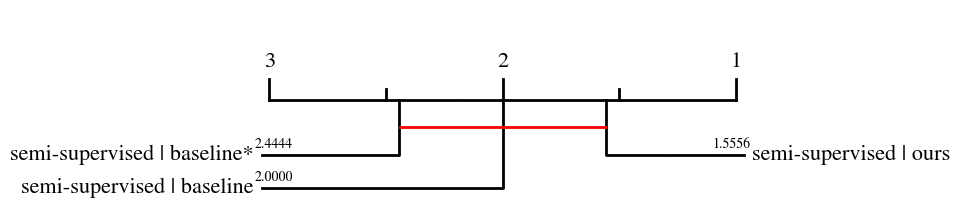

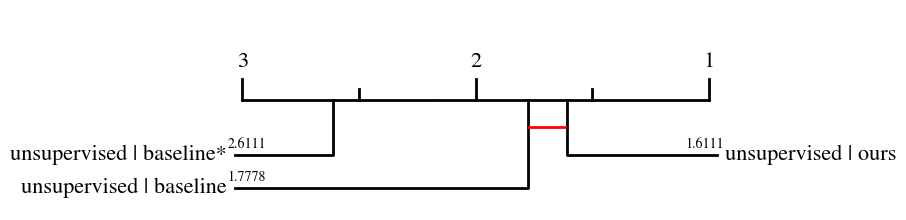

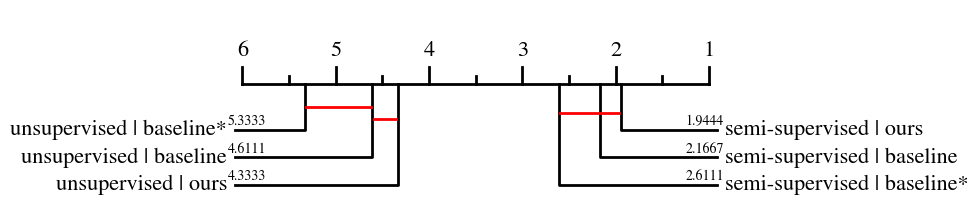

In [18]:
from matplotlib import pyplot as plt
from cd_diagram import make_diagram
from pandas import Index

def merge_column_levels(columns: Index) -> Index:
    merged_columns = columns.map(" | ".join)
    merged_columns.names = [" | ".join(columns.names)]
    return merged_columns

df = pd.concat([
    paper_df.loc[:, ("semi-supervised", slice(None))],
    pt_test_avg.loc[:, ("semi-supervised", slice(None))], 
    paper_df.loc[:, ("unsupervised", slice(None))],
    pt_test_avg.loc[:, ("unsupervised", slice(None))], 
], axis=1)

compare_every_n = 3
colidx = 0

df = df.droplevel(axis='index', level=0)
df.columns = merge_column_levels(df.columns)

compare_every_n = 3
colidx = 0
df_plot = df.iloc[:, compare_every_n * colidx:compare_every_n * (colidx + 1)]
df_plot = df_plot.stack().reset_index()
df_plot = df_plot.rename(columns={df_plot.columns[0]: "dataset", df_plot.columns[1]: "model", 0: "metric"})

fig = plt.figure(figsize=(7, 2), dpi=100)
p_values, average_ranks, _, ax = make_diagram(df_plot, alpha=0.10, fig=fig,)
fig.show()

compare_every_n = 3
colidx = 1
df_plot = df.iloc[:, compare_every_n * colidx:compare_every_n * (colidx + 1)]
df_plot = df_plot.stack().reset_index()
df_plot = df_plot.rename(columns={df_plot.columns[0]: "dataset", df_plot.columns[1]: "model", 0: "metric"})

fig = plt.figure(figsize=(7, 2), dpi=100)
p_values, average_ranks, _, ax = make_diagram(df_plot, alpha=0.10, fig=fig,)
fig.show()


compare_every_n = 6
colidx = 0
df_plot = df.iloc[:, compare_every_n * colidx:compare_every_n * (colidx + 1)]
df_plot = df_plot.stack().reset_index()
df_plot = df_plot.rename(columns={df_plot.columns[0]: "dataset", df_plot.columns[1]: "model", 0: "metric"})

fig = plt.figure(figsize=(7, 2), dpi=100)
p_values, average_ranks, _, ax = make_diagram(df_plot, alpha=0.10, fig=fig,)
fig.show()

# avg precision

In [19]:
metric = "test/avg-precision"
mean_column = (metric, "mean")
std_column = (metric, "std")
pt_test_avg = make_totals(pt_all_metrics[mean_column])
pt_test_std = make_totals(pt_all_metrics[std_column])
pt_composed = pt_test_avg.applymap("{:.1f}".format) + " " + pt_test_std.applymap("({:.1f})".format)

In [20]:
pt = pt_composed.copy()
pt_color_from = pt_test_avg.copy()

pt.rename(
    columns={
        "semi-supervised": "semi-supervised (1 real anomaly / anomaly type)",
        "unsupervised": "unsupervised (synthetic confetti noise)"
    },
    index={
    },
    inplace=True,
)
pt.columns.rename({"supervise_mode": "supervision", "loss_mode": "loss"}, inplace=True)
pt.index.rename({"normal_class_fullqualified": "class", "mvtec_class_type": "class type"}, inplace=True)
def format_index(index):
    ktype, klass = index
    # get rid of number
    klass = klass[3:] if not klass.endswith("mean") else klass
    klass = klass.replace("_", " ")
    return (ktype, klass)
pt.index = pt.index.map(format_index)

color_mask = get_color_mask_compare_by_line_every_n_cols(pt_color_from, n=2)
pt = pt.style.apply(bold_from_ordering_mask(color_mask), axis=None)
pt

print(pt.to_latex())

\begin{tabular}{llllll}
 & supervision & \multicolumn{2}{r}{semi-supervised (1 real anomaly / anomaly type)} & \multicolumn{2}{r}{unsupervised (synthetic confetti noise)} \\
 & loss & baseline & ours & baseline & ours \\
class type & class &  &  &  &  \\
\multirow[c]{10}{*}{object} & bottle & 66.1 (6.8) & \font-weightbold 66.4 (9.1) & \font-weightbold 54.6 (2.0) & 53.0 (2.2) \\
 & cable & \font-weightbold 62.8 (2.2) & 61.1 (1.6) & \font-weightbold 54.6 (1.2) & 54.4 (0.8) \\
 & capsule & 18.5 (6.4) & \font-weightbold 19.6 (9.0) & 26.3 (1.8) & \font-weightbold 28.4 (2.5) \\
 & hazelnut & 52.8 (12.1) & \font-weightbold 57.5 (15.1) & 36.6 (1.6) & \font-weightbold 38.9 (3.6) \\
 & metal nut & \font-weightbold 92.5 (1.0) & 92.2 (0.8) & 46.0 (28.2) & \font-weightbold 65.1 (2.4) \\
 & pill & 72.1 (9.5) & \font-weightbold 80.5 (5.9) & \font-weightbold 38.2 (1.1) & 34.2 (3.1) \\
 & screw & 6.6 (1.9) & \font-weightbold 9.1 (1.8) & \font-weightbold 1.3 (0.1) & 1.3 (0.3) \\
 & toothbrush & \font-we

computing
drawing fig


/tmp/ipykernel_143222/1322126546.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


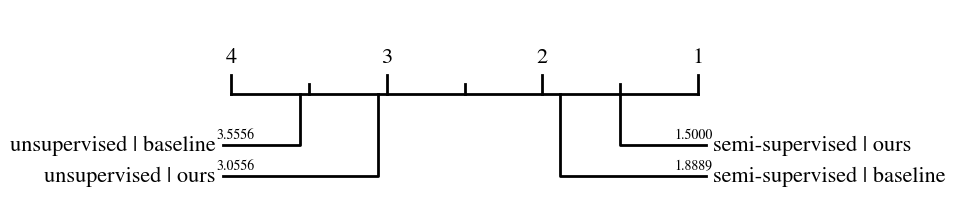

In [21]:
%matplotlib inline
from cd_diagram import make_diagram
from pandas import Index

def merge_column_levels(columns: Index) -> Index:
    merged_columns = columns.map(" | ".join)
    merged_columns.names = [" | ".join(columns.names)]
    return merged_columns

df = pt_test_avg.copy()

compare_every_n = 4
colidx = 0

df = df.droplevel(axis='index', level=0)
df.columns = merge_column_levels(df.columns)

df = df.iloc[:, compare_every_n * colidx:compare_every_n * (colidx + 1)]
df = df.stack().reset_index()
df = df.rename(columns={df.columns[0]: "dataset", df.columns[1]: "model", 0: "metric"})

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(7, 2), dpi=100)
p_values, average_ranks, _, ax = make_diagram(df, alpha=0.10, fig=fig,)
fig.show()